# Model Training

In [2]:
# !pip install tensorflow
# !pip install xgboost
# !pip install imblearn

In [145]:
# Importing Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from IPython.display import display, Markdown, Latex
from pylab import *
import pickle as pk
import random
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import backend as B
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
# Defining function to visualise 

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.005)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
# Taken from Zach (2021). 

# Selecting Models Methodology

1. Explore several classifiers. Choose the best classifier on the validation set. 
2. Hypertune parameters. Choose best model to test at the final stage, and also for applying sampling methods later.
3. Try undersampling (with hypertuned model). If a particular setting/parameter seems promising, select it to test at the end.
4. Try oversampling (with hypertuned model). If a particular setting/parameter seems promising, select it to test at the end.
5. Explore combination of undersampling and oversampling. If a particular combination of setting/parameters seems promising, select it to test at the end.
6. Should have 2-5 variations of the chosen classifier from the 1st step. Train them on entire training set, and test on the test set reserved for the very end. 
7. Select the best model for interpretability. 

## Understanding Distributions of Data

In [328]:
# Loading

p_train = pd.read_csv('./Train_Validation_Test/train_final.csv')
Train = pd.read_csv('./Train_Validation_Test/TRUE_TRAIN.csv')
val = pd.read_csv('./Train_Validation_Test/val_final.csv')
Test = pd.read_csv('./Train_Validation_Test/TRUE_TEST.csv')

In [406]:
all_features_table = p_train.columns.to_frame()
all_features_table

,0
percentage of males,percentage of males
% of children,% of children
% of teenager,% of teenager
% of adult,% of adult
% of senior,% of senior
unique_listener,unique_listener
listened_count,listened_count
artist_passion_score,artist_passion_score
Playlist Passion Score,Playlist Passion Score
Success,Success


In [330]:
# Drop columns

p_train.drop('artist_name', axis=1, inplace=True)
Train.drop('artist_name', axis=1, inplace=True)
val.drop('artist_name', axis=1, inplace=True)
Test.drop('artist_name', axis=1, inplace=True)

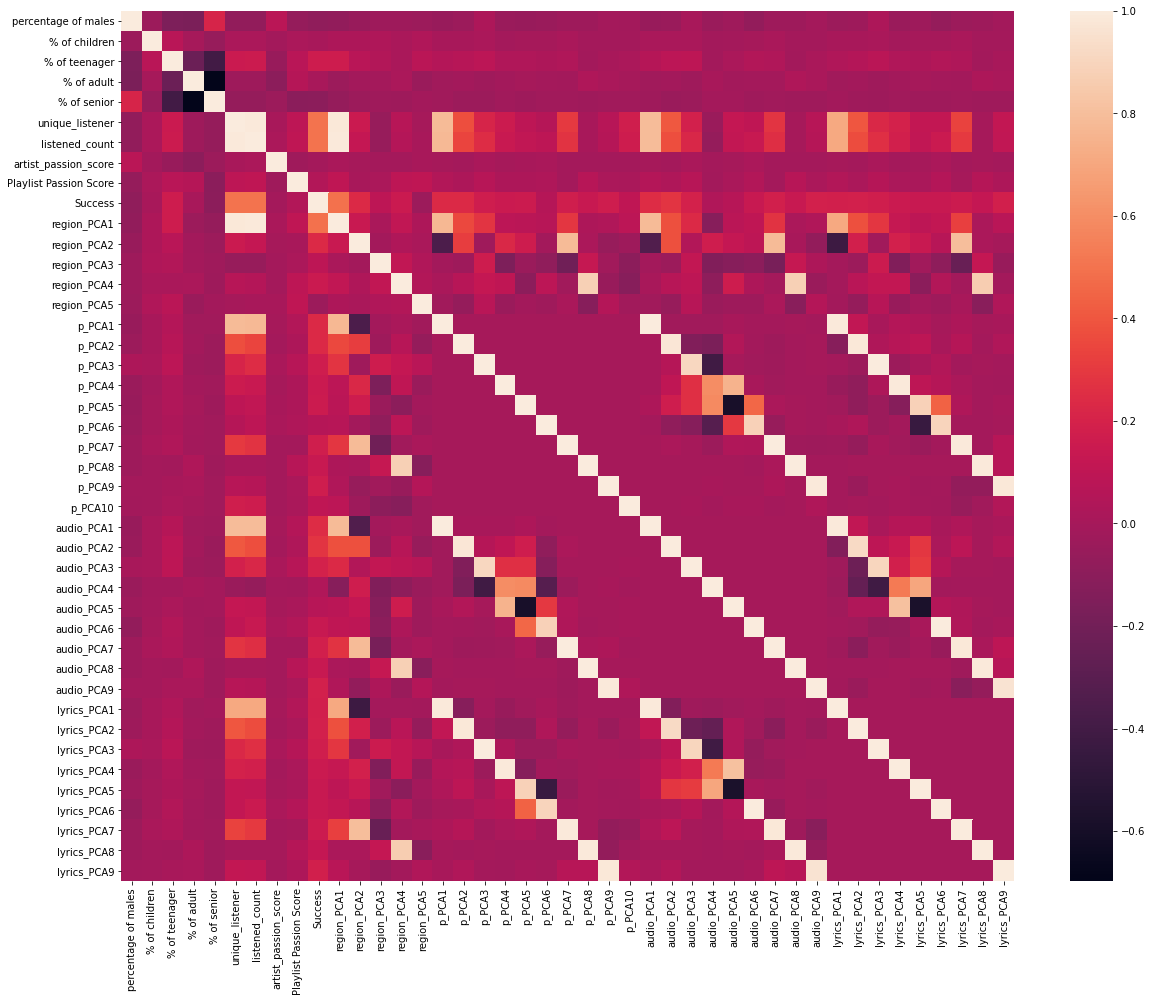

In [333]:
# Checking correlation matrix

plt.figure(figsize=(20,16))
sns.heatmap(Train.corr());

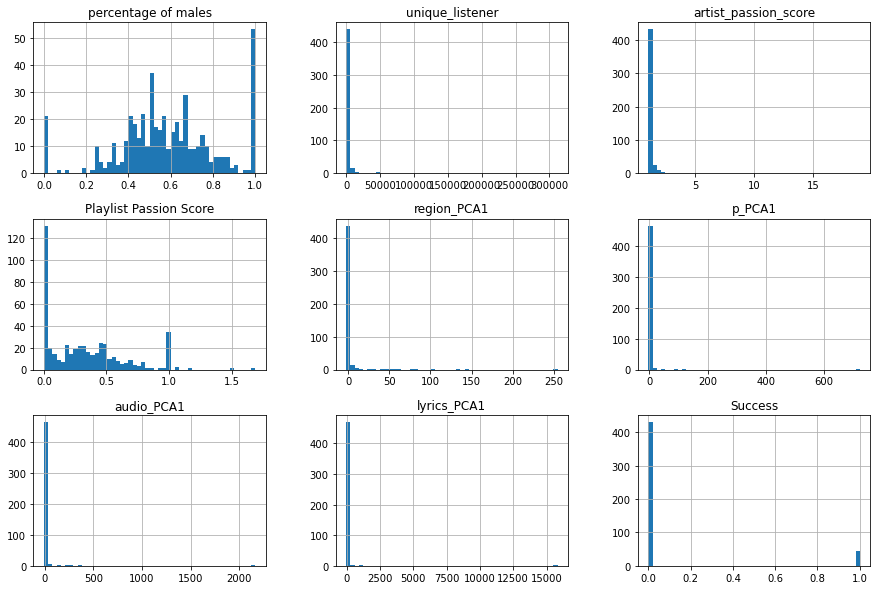

In [7]:
# Getting idea of data through train set

some_columns_viz = ['percentage of males', 'unique_listener', 'artist_passion_score', 'Playlist Passion Score', 
                    'region_PCA1', 'p_PCA1', 'audio_PCA1', 'lyrics_PCA1', 'Success']
Train[some_columns_viz].hist(bins=50, figsize=(15,10)) 
plt.show();

**Comment:** Unique listeners has a high outlier range of up to 300000. 

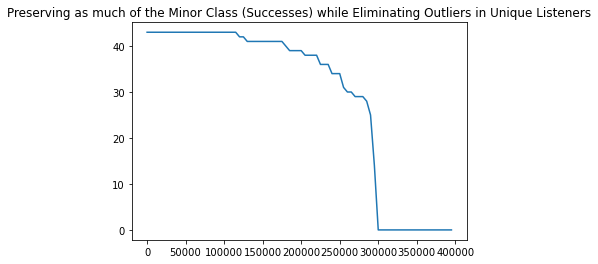

In [8]:
# How many of the minor class can we preserve removing outliers

temp1 = []
temp2 = list(range(0, 400000, 5000))
for i in temp2:
    temp3 = Train[Train.unique_listener < 300000 - i].Success.sum()
    temp1.append(temp3)
    
sns.lineplot(x=temp2, y=temp1)
plt.title('Preserving as much of the Minor Class (Successes) while Eliminating Outliers in Unique Listeners')
plt.show(); 

In [7]:
# How many of the minor class can we preserve removing outliers

Train[Train.unique_listener < 300000-230000].Success.sum()

36

In [8]:
# Number of rows lost after removing outliers

len(Train) - len(Train[Train.unique_listener < 300000-230000])

8

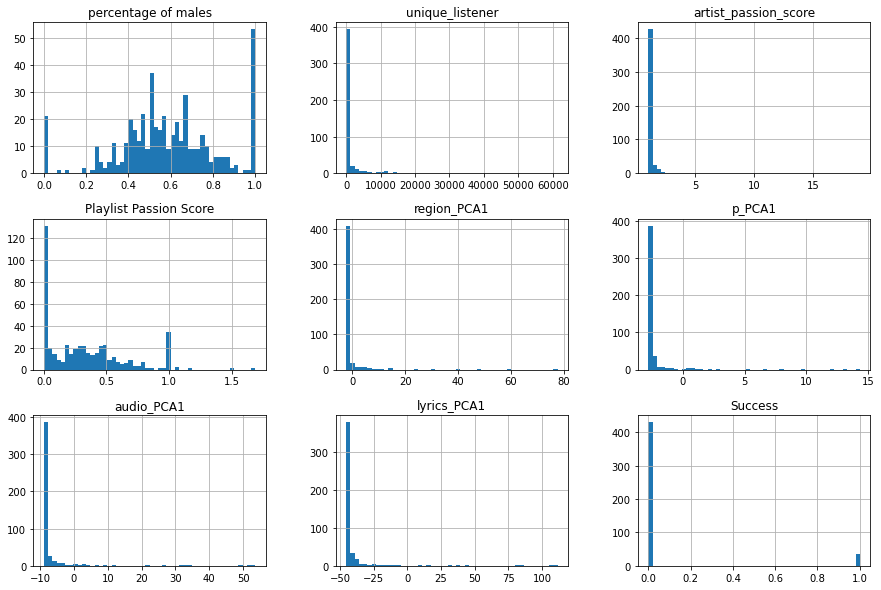

In [271]:
# Application of Outlier Removal

some_columns_viz = ['percentage of males', 'unique_listener', 'artist_passion_score', 'Playlist Passion Score', 
                    'region_PCA1', 'p_PCA1', 'audio_PCA1', 'lyrics_PCA1', 'Success']
Train[Train.unique_listener < 300000-230000][some_columns_viz].hist(bins=50, figsize=(15,10)) 
plt.show();

**Comment:** Improvements are seen across all scales, except Artist Passion Score. The outlier removal will be applied

In [9]:
# Changes made: 

p_train = p_train[p_train.unique_listener < 300000-230000]
Train = Train[Train.unique_listener < 300000-230000]

### Extra data viz for just some relationships with PCA components

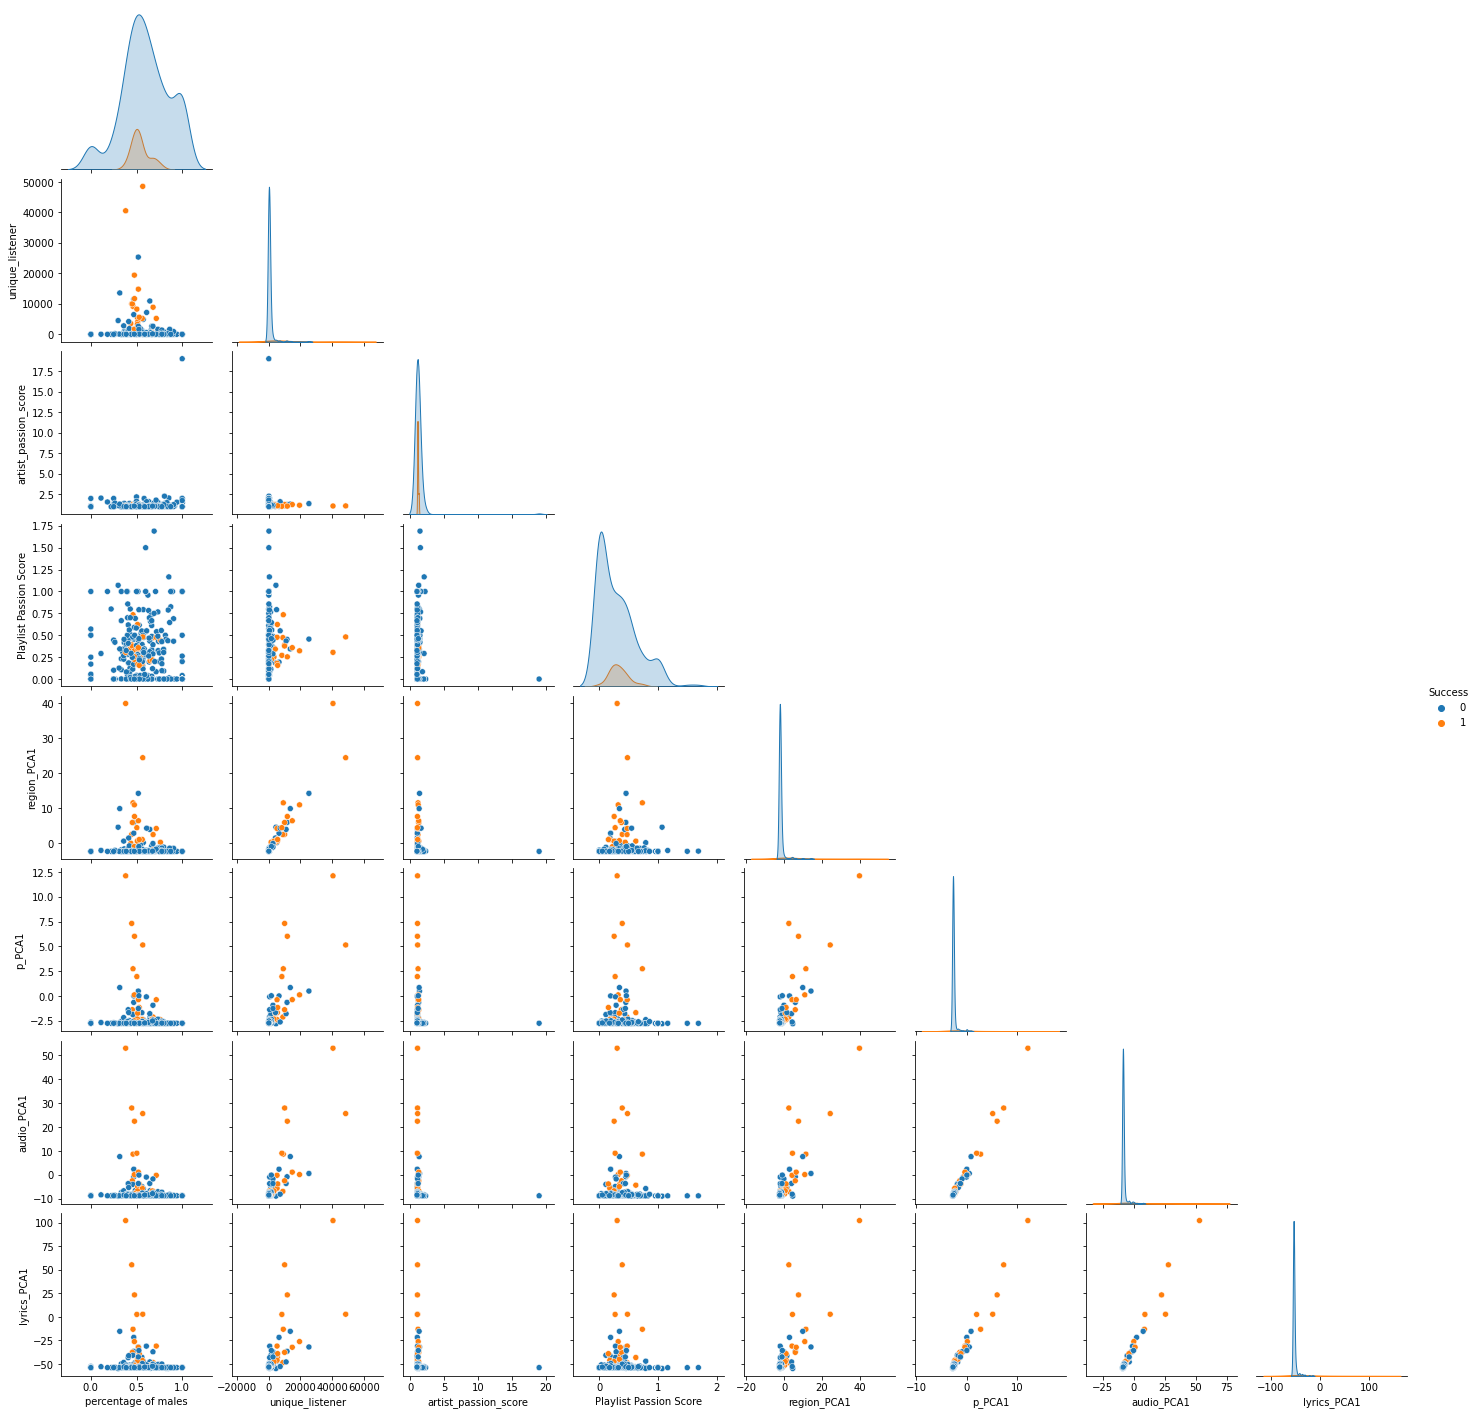

In [10]:
# Checking for polynomial terms

some_columns_viz = ['percentage of males', 'unique_listener', 'artist_passion_score', 'Playlist Passion Score', 
                    'region_PCA1', 'p_PCA1', 'audio_PCA1', 'lyrics_PCA1', 'Success']
sns.pairplot(p_train[some_columns_viz], hue='Success', corner=True)
plt.show(); 

### Extra Data Viz between 1st and 2nd Components from the 4 PCA models - (Region, Playlist Streams, Audio Features, and Lyrics)

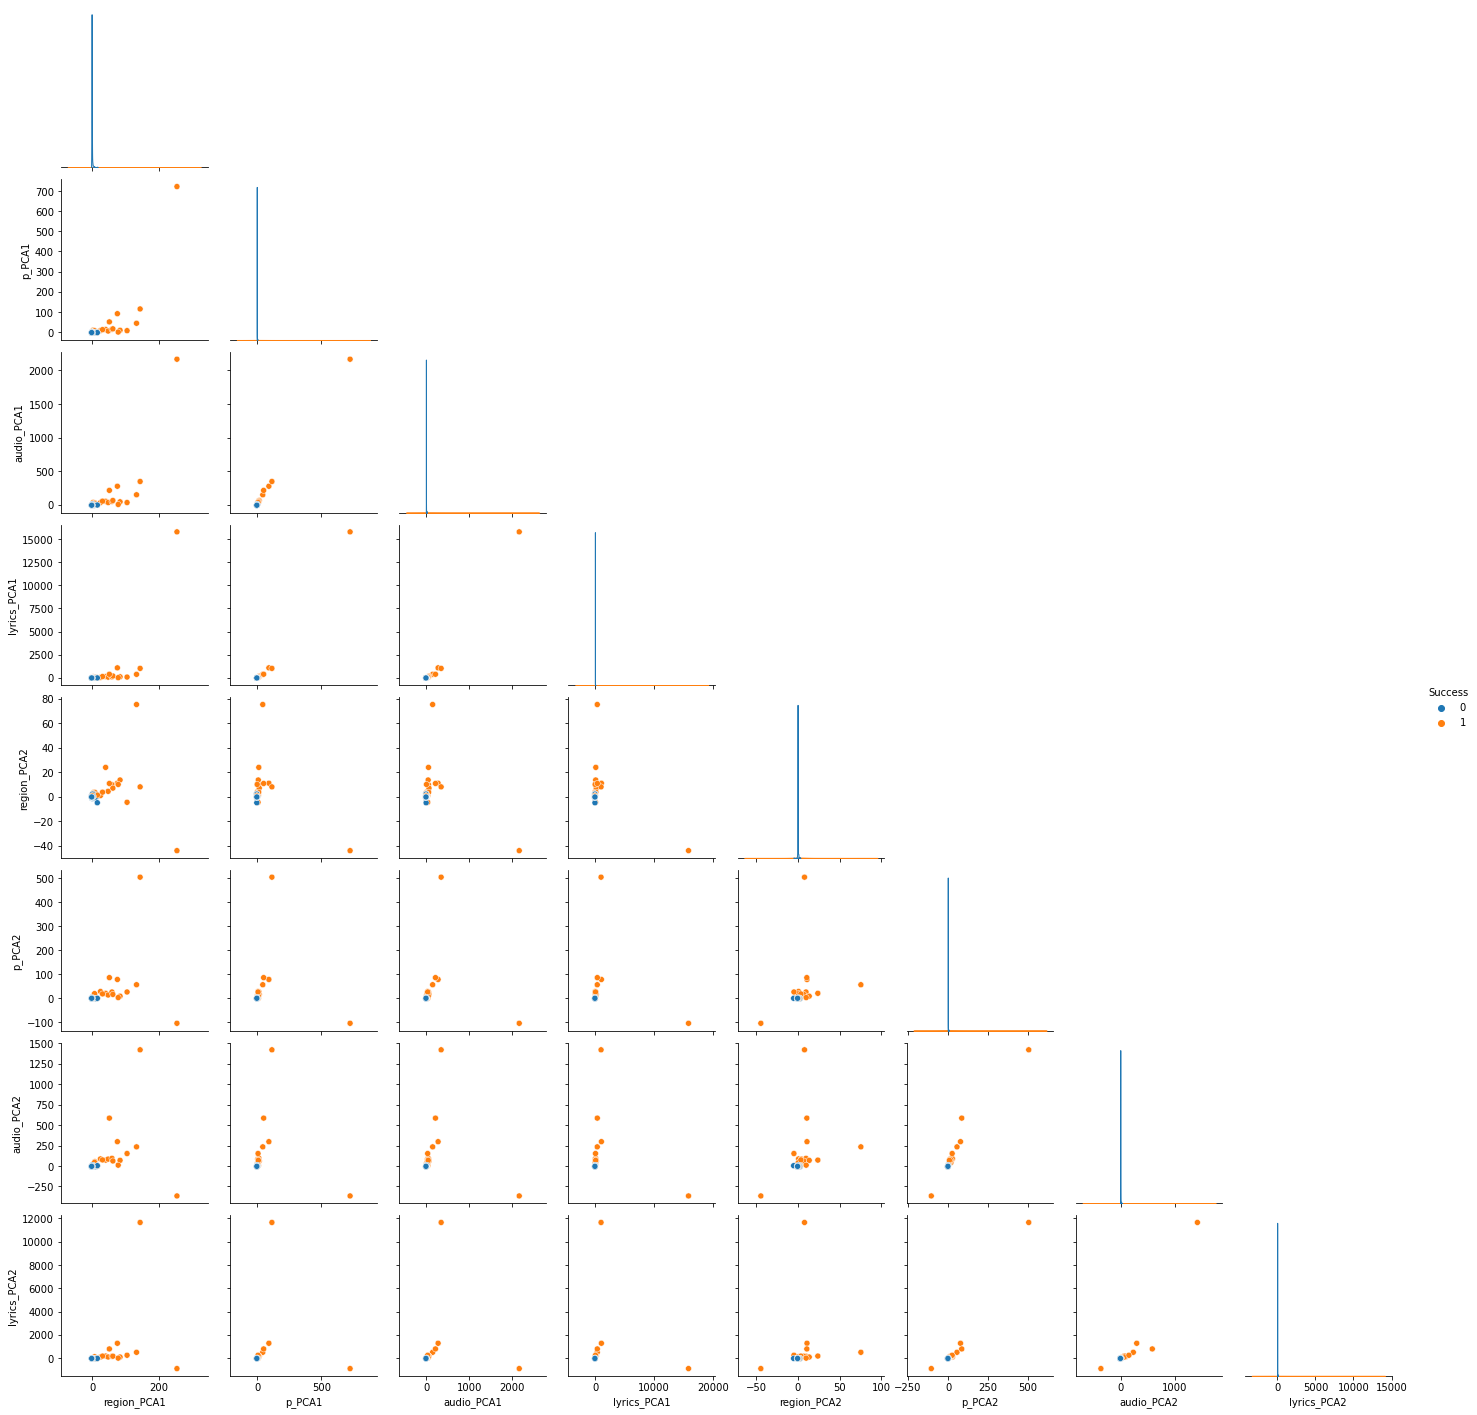

In [347]:
# Checking for PCA patterns

some_columns_viz = ['region_PCA1', 'p_PCA1', 'audio_PCA1', 'lyrics_PCA1', 
                    'region_PCA2', 'p_PCA2', 'audio_PCA2', 'lyrics_PCA2',
                    'Success']
sns.pairplot(Train[some_columns_viz], hue='Success', corner=True)
plt.show(); 

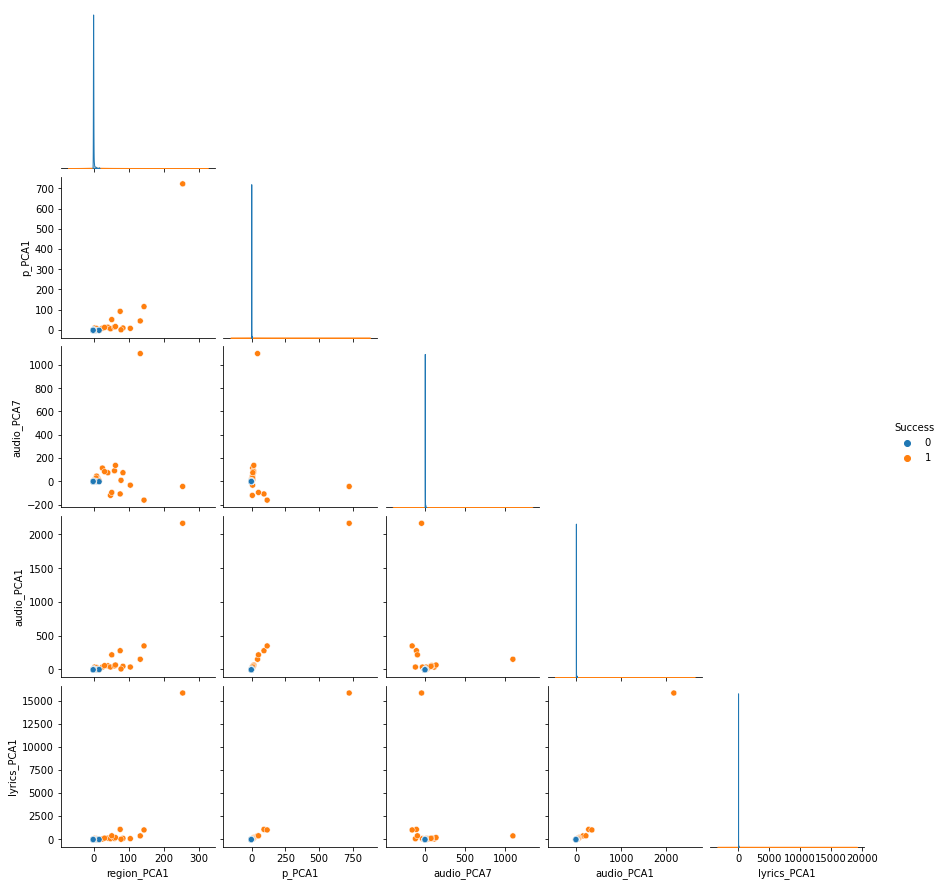

In [348]:
some_columns_viz = ['region_PCA1', 'p_PCA1', 'audio_PCA7', 'audio_PCA1', 'lyrics_PCA1', 'Success']
sns.pairplot(Train[some_columns_viz], hue='Success', corner=True)
plt.show(); 

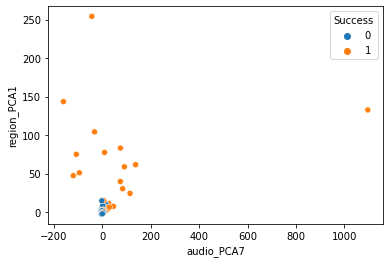

In [352]:
sns.scatterplot(x='audio_PCA7', y='region_PCA1', data=Train, hue='Success');

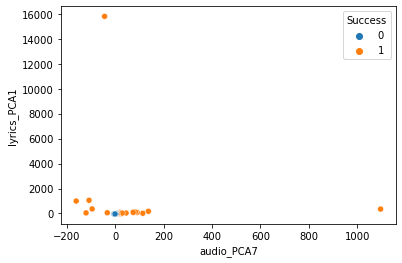

In [353]:
sns.scatterplot(x='audio_PCA7', y='lyrics_PCA1', data=Train, hue='Success');

## Setting up Models

In [13]:
# Getting the datasets ready

X_train = p_train.drop('Success', axis=1)
y_train = p_train['Success']

X_val = val.drop('Success', axis=1)
y_val = val['Success']

X_fulltrain = Train.drop('Success', axis=1)
y_fulltrain = Train['Success']

X_test = Test.drop('Success', axis=1)
y_test = Test['Success']

In [170]:
# Base Models with Default Parameters

# Setting seed
random.seed(101)
np.random.seed(101)
tf.random.set_seed(101)

# Keras basic ANN
def ann_clf():
    model=Sequential()
    model.add(Dense(30,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.Precision(name='precision'),
                           metrics.Recall(name='recall')])
    return model

k_clf = KerasClassifier(build_fn = ann_clf, epochs=10, verbose=0)

# Models
log = Pipeline(steps=[('standardise', StandardScaler()), ('log', LogisticRegression())])
dtree = DecisionTreeClassifier(random_state=101)
rfc = RandomForestClassifier(random_state=101)
ada = AdaBoostClassifier(random_state=101)
xgb = XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, random_state=101)
svc = Pipeline(steps=[("standardise", StandardScaler()), ("svc", svm.SVC(kernel='linear'))])
ann = Pipeline(steps=[('standardise', StandardScaler()), ('ann', k_clf)])

## Shortlisting - Use: Partial Train Set and Validation Set

In [285]:
# Fitting

classifiers = [log, dtree, rfc, ada, xgb, svc, ann]
labels = ['log', 'dtree', 'rfc', 'ada', 'xgb', 'svc', 'ann']

def shortlist_models(classifiers, labels, X_train, y_train, X_val, y_val, stage):
    accuracies_train = []
    f1_scores_train = []
    recalls_train = []
    precisions_train = []
    accuracies_val = []
    f1_scores_val = []
    recalls_val = []
    precisions_val = []
    if stage == 1:
        evaluated_on = ['train']*len(labels) + ['validation']*len(labels)
    else:
        evaluated_on = ['train']*len(labels) + ['test']*len(labels)
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        pred_on_train = classifier.predict(X_train)
        pred_on_val = classifier.predict(X_val)
        
        accuracy_train = accuracy_score(y_train, pred_on_train)
        accuracy_val = accuracy_score(y_val, pred_on_val)
        f1_train = f1_score(y_train, pred_on_train)
        f1_val = f1_score(y_val, pred_on_val)
        recall_train = recall_score(y_train, pred_on_train)
        recall_val = recall_score(y_val, pred_on_val)
        precision_train = precision_score(y_train, pred_on_train)
        precision_val = precision_score(y_val, pred_on_val)
        
        accuracies_train.append(accuracy_train)
        f1_scores_train.append(f1_train)
        recalls_train.append(recall_train)
        precisions_train.append(precision_train)
        accuracies_val.append(accuracy_val)
        f1_scores_val.append(f1_val)
        recalls_val.append(recall_val)
        precisions_val.append(precision_val)
    
    temp_dict = {'model': labels*2, 'evaluated_on': evaluated_on, 'accuracy': accuracies_train+accuracies_val, 
                 'f1_score': f1_scores_train+f1_scores_val, 'recall': recalls_train+recalls_val, 
                 'precision': precisions_train+precisions_val}
        
    df = pd.DataFrame(temp_dict)
    
    return df
        

In [25]:
# Evaluate Models

warnings.filterwarnings('ignore')
evaluation_shortlist = shortlist_models(classifiers, labels, X_train, y_train, X_val, y_val, 1)

In [26]:
evaluation_shortlist

,model,evaluated_on,accuracy,f1_score,recall,precision
0,log,train,0.943463,0.578947,0.458333,0.785714
1,dtree,train,1.000000,1.000000,1.000000,1.000000
2,rfc,train,1.000000,1.000000,1.000000,1.000000
3,ada,train,1.000000,1.000000,1.000000,1.000000
4,xgb,train,1.000000,1.000000,1.000000,1.000000
5,svc,train,0.946996,0.545455,0.375000,1.000000
6,ann,train,0.929329,0.411765,0.291667,0.700000
7,log,validation,0.921053,0.516129,0.444444,0.615385
8,dtree,validation,0.857895,0.372093,0.444444,0.320000
9,rfc,validation,0.936842,0.666667,0.666667,0.666667


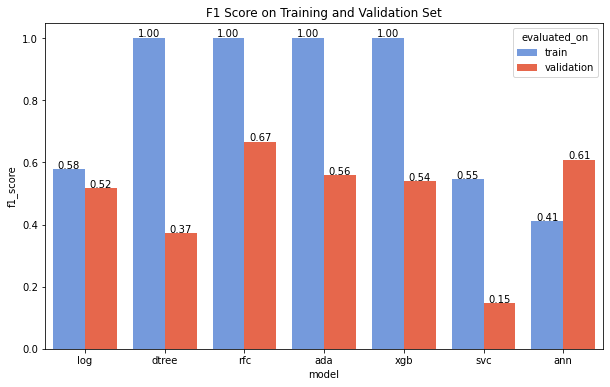

In [363]:
# Visualising results

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='f1_score', hue='evaluated_on', data=evaluation_shortlist, palette=['#6495ED', '#FF5733'])
plt.title('F1 Score on Training and Validation Set')
show_values(g)
plt.savefig('./Model_Evaluation_Images/shortlisting_models.png',  bbox_inches='tight')

**Comment:** Random Forest has the highest f1-score on the validation set, given having maximum performance on training set. It does indicate overfitting, however. Neural networks perform the 2nd best on validation, but its performance on training set is the lowest, and implies it is by chance. Hence, we will go through with just hypertuning Random Forest.

## Feature Selection

### Feature Importance

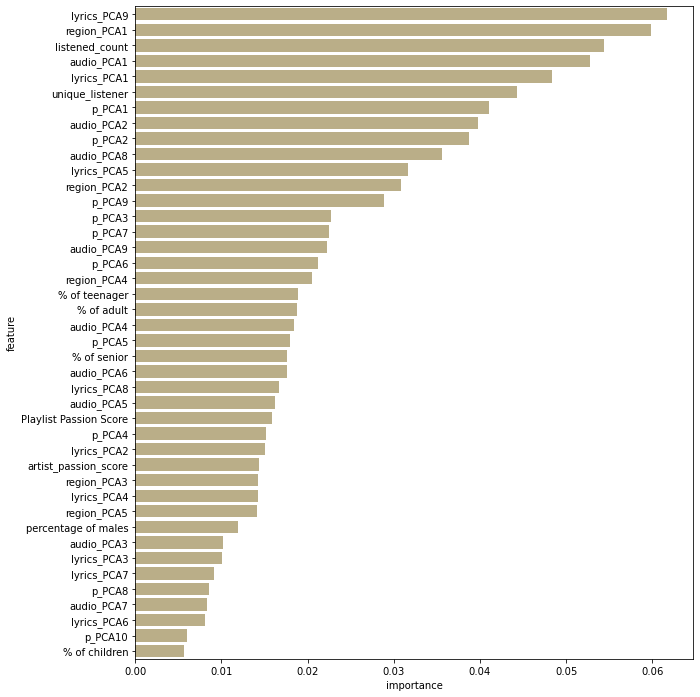

In [28]:
#  Feature Importances from Random Forest

temp_x = X_train.columns.tolist()
temp_y = rfc.feature_importances_
temp_df = pd.DataFrame({'feature': temp_x, 'importance': temp_y})
temp_df.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(10,12))
sns.barplot(x='importance', y='feature', data=temp_df, color='#C2B280')
plt.show();

In [29]:
# Checking the lowest ones between both tree-based models

least_important_rfc = temp_df[temp_df.importance < 0.03].feature.tolist()
eliminate_features1 = least_important_rfc
eliminate_features1

['p_PCA9',
 'p_PCA3',
 'p_PCA7',
 'audio_PCA9',
 'p_PCA6',
 'region_PCA4',
 '% of teenager',
 '% of adult',
 'audio_PCA4',
 'p_PCA5',
 '% of senior',
 'audio_PCA6',
 'lyrics_PCA8',
 'audio_PCA5',
 'Playlist Passion Score',
 'p_PCA4',
 'lyrics_PCA2',
 'artist_passion_score',
 'region_PCA3',
 'lyrics_PCA4',
 'region_PCA5',
 'percentage of males',
 'audio_PCA3',
 'lyrics_PCA3',
 'lyrics_PCA7',
 'p_PCA8',
 'audio_PCA7',
 'lyrics_PCA6',
 'p_PCA10',
 '% of children']

### Anova and Lasso

In [30]:
# Import the necessary libraries first

from sklearn import feature_selection
from sklearn import linear_model
feature_names = X_train.columns

In [31]:
## Anova

selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=10).fit(X_train, y_train)
anova_selected_features = feature_names[selector.get_support()]

In [32]:
## Lasso regularization

selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X_train, y_train)
lasso_selected_features = feature_names[selector.get_support()]

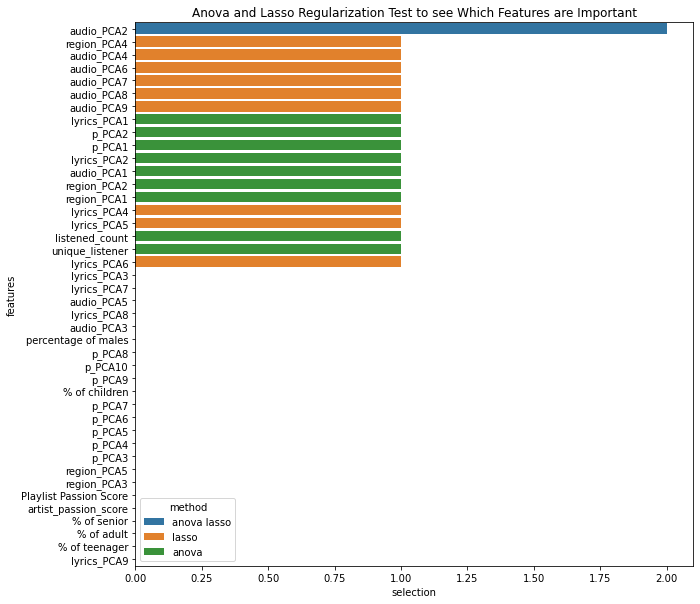

In [365]:
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
plt.figure(figsize=(10,10))
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)
plt.title('Anova and Lasso Regularization Test to see Which Features are Important')
plt.savefig('./Model_Evaluation_Images/feature_selection_part2.png',  bbox_inches='tight')

In [34]:
least_important_ANOVA_Lasso = dtf_features[dtf_features.selection==0].features.tolist()
eliminate_features2 = list(set(least_important_ANOVA_Lasso).intersection(eliminate_features1))
final_eliminate = eliminate_features2
final_eliminate

['p_PCA7',
 'p_PCA6',
 'p_PCA3',
 'lyrics_PCA8',
 'p_PCA5',
 'audio_PCA3',
 'p_PCA4',
 'region_PCA5',
 '% of adult',
 'lyrics_PCA3',
 'lyrics_PCA7',
 'Playlist Passion Score',
 '% of teenager',
 'p_PCA10',
 'artist_passion_score',
 'audio_PCA5',
 'p_PCA8',
 'region_PCA3',
 'percentage of males',
 '% of children',
 'p_PCA9',
 '% of senior']

In [35]:
# Restate

final_eliminate = ['p_PCA7',
 'p_PCA6',
 'p_PCA3',
 'lyrics_PCA8',
 'p_PCA5',
 'audio_PCA3',
 'p_PCA4',
 'region_PCA5',
 '% of adult',
 'lyrics_PCA3',
 'lyrics_PCA7',
 'Playlist Passion Score',
 '% of teenager',
 'p_PCA10',
 'artist_passion_score',
 'audio_PCA5',
 'p_PCA8',
 'region_PCA3',
 'percentage of males',
 '% of children',
 'p_PCA9',
 '% of senior']

In [36]:
len(final_eliminate)

22

**Comment:** 22 features will be dropped. These results are consistent between Random Forest and Lasso and ANOVA.

In [37]:
# Drop the columns

X_train.drop(final_eliminate, axis=1, inplace=True)
X_val.drop(final_eliminate, axis=1, inplace=True)
X_fulltrain.drop(final_eliminate, axis=1, inplace=True)
X_test.drop(final_eliminate, axis=1, inplace=True)

In [38]:
# Total number of features now

len(X_train.columns)

20

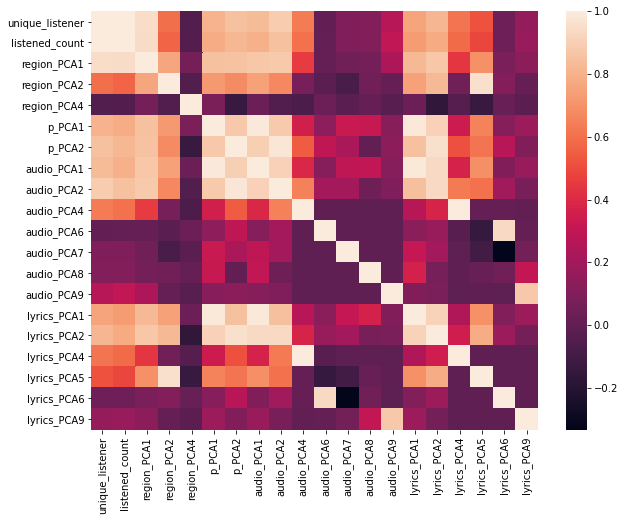

In [74]:
# Correlation matrix among remaining columns

plt.figure(figsize=(10,7.7))
sns.heatmap(X_train.corr())
plt.show();

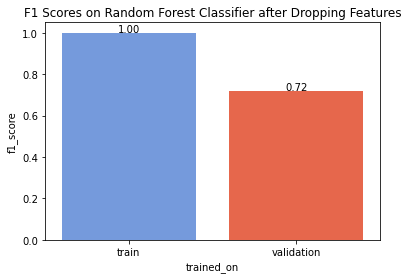

In [370]:
# Checking performance of new rfc

rfc = RandomForestClassifier(random_state=101)
rfc.fit(X_train, y_train)
pred_on_val = rfc.predict(X_val).tolist()
pred_on_train = rfc.predict(X_train).tolist()
val_f1_score = f1_score(y_val, pred_on_val)
train_f1_score = f1_score(y_train, pred_on_train)
f1_scores = [train_f1_score, val_f1_score]
labels = ['train', 'validation']
temp_df = pd.DataFrame({'trained_on':labels, 'f1_score': f1_scores})
g = sns.barplot(x='trained_on', y='f1_score', data=temp_df, palette=['#6495ED', '#FF5733'])
plt.title('F1 Scores on Random Forest Classifier after Dropping Features')
show_values(g)
plt.savefig('./Model_Evaluation_Images/feature_removal_improvement.png',  bbox_inches='tight')

**Comment:** We see an immediate increase. We will continue with these features. 

## Hyperparamater Tuning

In [622]:
# DO NOT RUN FROM HERE. SKIP TO GRID SEARCH RESULTS

MANDATORY STOPPER

In [43]:
# Processing for GridSearch on Validation Set

X_train_val_comb = pd.concat([X_train.copy(), X_val.copy()])
y_train_val_comb = pd.concat([y_train.copy(), y_val.copy()])

In [69]:
# Comparing against train set

X_train_train_comb = pd.concat([X_train.copy(), X_train.copy()])
y_train_train_comb = pd.concat([y_train.copy(), y_train.copy()])

In [70]:
# Determine which is train and which is validation

split_index2 = [-1]*len(X_train) + [0]*len(X_train)
pds2 = PredefinedSplit(test_fold = split_index)

In [ ]:
# Determine which is train and which is validation

In [232]:
# Redefining the shortlisted model

rfc = RandomForestClassifier(criterion = 'gini', random_state=101, n_jobs=-1)

In [233]:
# Setting params

param_grid_rfc = {
    "n_estimators": [30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300], 
    "max_depth": [30, 40, 50, 70, 80],
    "min_samples_leaf": [1, 2, 3], 
    "min_samples_split": [2, 3], 
} # combinations


In [234]:
# Defining Grid Search 

# Scoring
scoring = ['recall', 'precision', 'f1', 'accuracy']

gs_rfc = GridSearchCV(rfc, param_grid_rfc, cv = pds, scoring=scoring, refit=False, n_jobs=-1)

In [237]:
# Fitting random forest

gs_rfc.fit(X_train_val_comb, y_train_val_comb)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [30, 40, 50, 70, 80],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [30, 40, 50, 60, 70, 80, 90, 100, 120,
                                          150, 200, 250, 300]},
             refit=False, scoring=['recall', 'precision', 'f1', 'accuracy'])

In [210]:
# gs_xgb.fit(X_train_val_comb, y_train_val_comb)

In [238]:
# Determining columns of interest

metrics_of_interest = ['mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy', 'mean_fit_time']
# log_params_columns = ['param_log__C', 'param_log__penalty', 'param_log__solver'] + metrics_of_interest
# dtree_params_columns = ['param_criterion', 'param_max_depth', 'param_min_samples_leaf', 
#                         'param_min_samples_split'] + metrics_of_interest
rfc_params_columns = ['param_max_depth', 'param_min_samples_leaf', 
                      'param_min_samples_split', 'param_n_estimators'] + metrics_of_interest
# xgb_params_columns = ['param_n_estimators', 'param_max_depth', 'param_eta', 
#                       'param_subsample', 'param_lambda'] + metrics_of_interest

## GridSearch Results

In [239]:
# assigning results to variables, and saving them

# Assigning dataframes to variables
# log_grid_results = pd.DataFrame(gs_log.cv_results_).sort_values(by='mean_test_f1', ascending=False)[log_params_columns]
# dtree_grid_results = pd.DataFrame(gs_dtree.cv_results_).sort_values(by='mean_test_f1', ascending=False)[dtree_params_columns]
rfc_grid_results = pd.DataFrame(gs_rfc.cv_results_).sort_values(by='mean_test_f1', ascending=False)[rfc_params_columns]
# xgb_grid_results = pd.DataFrame(gs_xgb.cv_results_).sort_values(by='mean_test_f1', ascending=False)[xgb_params_columns]

# Saving
# log_grid_results.to_csv('./gridsearch_results/log_grid_results.csv', index=False)
# dtree_grid_results.to_csv('./gridsearch_results/dtree_grid_results.csv', index=False)
rfc_grid_results.to_csv('./gridsearch_results/rfc_grid_results.csv', index=False)
# xgb_grid_results.to_csv('./gridsearch_results/xgb_grid_results.csv', index=False)

In [240]:
# Load

# log_grid_results = pd.read_csv('./gridsearch_results/log_grid_results.csv')
# dtree_grid_results = pd.read_csv('./gridsearch_results/dtree_grid_results.csv')
rfc_grid_results = pd.read_csv('./gridsearch_results/rfc_grid_results.csv')
# xgb_grid_results = pd.read_csv('./gridsearch_results/xgb_grid_results.csv')

**Note:** Multiple parameter combinations have the same scores across the different metrics. We will optimise on efficiency by choosing the one with the lowest fit amongst the best scoring ones. 

In [241]:
# Checking log scores

# log_grid_highest = log_grid_results[log_grid_results.mean_test_f1 == log_grid_results.mean_test_f1.max()]
# log_grid_highest[log_grid_highest.mean_fit_time == log_grid_highest.mean_fit_time.min()] # Which was has the lower fit time?

In [242]:
# Checking decision tree scores

# dtree_grid_highest = dtree_grid_results[dtree_grid_results.mean_test_f1 == dtree_grid_results.mean_test_f1.max()]
# dtree_grid_highest[dtree_grid_highest.mean_fit_time == dtree_grid_highest.mean_fit_time.min()] # Which was has the lower fit time?

In [399]:
# Checking random forest scores

rfc_grid_highest = rfc_grid_results[rfc_grid_results.mean_test_f1 == rfc_grid_results.mean_test_f1.max()]
rfc_best_params = rfc_grid_highest.iloc[0,:4].to_frame().reset_index()
rfc_best_params.columns =['parameter', 'value']
rfc_best_params

,parameter,value
0,param_max_depth,50.0
1,param_min_samples_leaf,3.0
2,param_min_samples_split,3.0
3,param_n_estimators,70.0


In [254]:
rfc_grid_highest.iloc[0, :]

param_max_depth            50.000000
param_min_samples_leaf      3.000000
param_min_samples_split     3.000000
param_n_estimators         70.000000
mean_test_f1                0.736842
mean_test_recall            0.777778
mean_test_precision         0.700000
mean_test_accuracy          0.947368
mean_fit_time               0.318745
Name: 0, dtype: float64

## Visualising Results from GridSearch

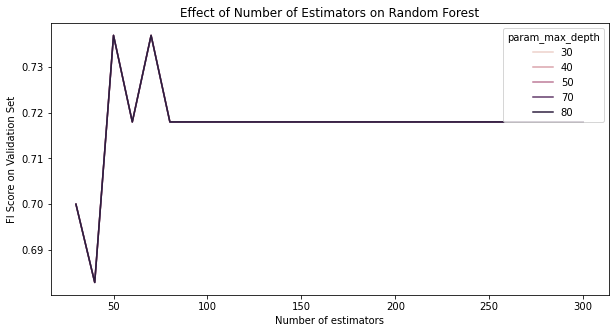

In [255]:
# Random Forest F1 with Gini and Min_sample_leaf==4, split=5, etc

plt.figure(figsize=(10,5))
sns.lineplot(y='mean_test_f1', x='param_n_estimators', 
             data=rfc_grid_results[(rfc_grid_results.param_min_samples_split == 3) & 
                                   (rfc_grid_results.param_min_samples_leaf == 3)], hue='param_max_depth')
plt.title('Effect of Number of Estimators on Random Forest')
plt.xlabel('Number of estimators')
plt.ylabel('Fl Score on Validation Set')
plt.show();

**Comment:** It seems that max depth has very little effect, as all the different max depths follow the same line

In [256]:
# Checking performance on train set as well

rfc_t = RandomForestClassifier(criterion='gini', random_state=101, n_jobs=-1)
gs_rfc_t = GridSearchCV(rfc_t, param_grid_rfc, cv = pds2, scoring=scoring, refit=False, n_jobs=-1)
gs_rfc_t.fit(X_train_train_comb, y_train_train_comb)
rfc_t_grid_results = pd.DataFrame(gs_rfc_t.cv_results_).sort_values(by='mean_test_f1', ascending=False)[rfc_params_columns]

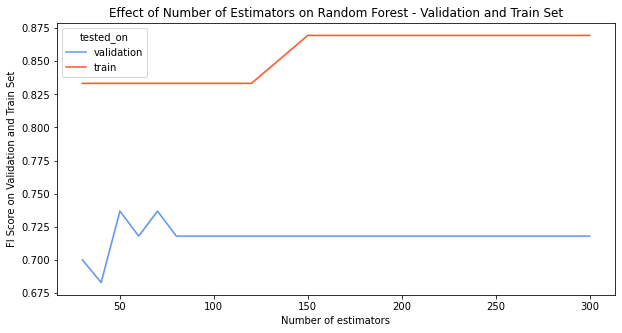

In [371]:
# Visualising val and train

rfc_vt = pd.concat([rfc_grid_results.copy(), rfc_t_grid_results.copy()])
rfc_vt['tested_on'] = ['validation']*len(rfc_grid_results) + ['train']*len(rfc_t_grid_results)

# Visualise
plt.figure(figsize=(10,5))
sns.lineplot(y='mean_test_f1', x='param_n_estimators', 
             data=rfc_vt[(rfc_vt.param_min_samples_split == 3) & 
                         (rfc_vt.param_min_samples_leaf == 3)], hue='tested_on', palette=['#6495ED', '#FF5733'])
plt.title('Effect of Number of Estimators on Random Forest - Validation and Train Set')
plt.xlabel('Number of estimators')
plt.ylabel('Fl Score on Validation and Train Set')
plt.savefig('./Model_Evaluation_Images/number_of_estimators.png',  bbox_inches='tight')

**Comment:** Lower number of estimators is preferred, particularly 50 and 70. Beyond 100 estimators expresses evident overfitting, and below 50 demonstrates an area of underfitting. While we use there hyperparameters, the f1 scores are not close to convergence, and variability is expected. 

## Exploring Undersampling and SMOTE

In [265]:
# Reconfirming ratio of minority over overall dataset

round(y_fulltrain.sum()/len(y_fulltrain),2)

0.08

### Undersampling - Near Miss Method

We will look to _______ for inspiration to test out different undersampling strategies. We will user RandomUnderSampler from the imblearn library.

In [267]:
# Redefining models with updated parameters

# log = Pipeline(steps=[('under', NearMiss()), 
#                       ('standardise', StandardScaler()), 
#                       ('log', LogisticRegression(C=1.1, penalty='l2', solver='sag'))])

# dtree = Pipeline(steps=[('under', NearMiss()),  
#                         ('dtree', DecisionTreeClassifier(criterion = 'gini', min_samples_leaf=1, 
#                                                          min_samples_split=5, max_depth=3, random_state=101))])

rfc_v = Pipeline(steps=[('under', RandomUnderSampler()),  
                      ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                                     min_samples_split=3, max_depth =50, n_estimators=70, 
                                                     random_state=101, n_jobs=-1))])

rfc_t = Pipeline(steps=[('under', RandomUnderSampler()),  
                      ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                                     min_samples_split=3, max_depth =50, n_estimators=70, 
                                                     random_state=101, n_jobs=-1))])


In [268]:
# Params to explore

param_under_sampling = {
    'under__sampling_strategy': [0.095, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
}

In [269]:
# Redefining Scoring

scoring = ['recall', 'precision', 'f1', 'accuracy']

In [270]:
# Undersampling grid search

# grid_search_log_undersampling = GridSearchCV(log, param_under_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
# grid_search_dtree_undersampling = GridSearchCV(dtree, param_under_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_v_undersampling = GridSearchCV(rfc_v, param_under_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_t_undersampling = GridSearchCV(rfc_t, param_under_sampling, cv=pds2, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)

In [271]:
# Fitting 

# grid_search_log_undersampling.fit(X_train_val_comb, y_train_val_comb)
# grid_search_dtree_undersampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_v_undersampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_t_undersampling.fit(X_train_train_comb, y_train_train_comb)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise',
             estimator=Pipeline(steps=[('under', RandomUnderSampler()),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=50,
                                                               min_samples_leaf=3,
                                                               min_samples_split=3,
                                                               n_estimators=70,
                                                               n_jobs=-1,
                                                               random_state=101))]),
             n_jobs=-1,
             param_grid={'under__sampling_strategy': [0.095, 0.1, 0.2, 0.3, 0.4,
                                                      0.5, 0.6]},
             refit=False, scoring=['recall', 'precision', 'f1', 'accuracy'])

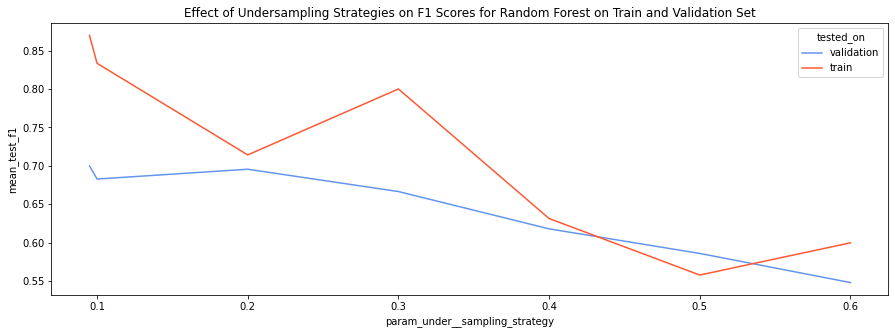

In [373]:
# Concatenating and saving

# Metrics of interest
metrics_of_interest = ['mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy', 'mean_fit_time']
undersamplings_metrics = ['param_under__sampling_strategy'] + metrics_of_interest

# Extracting the data from grid searches
gsrus_v = pd.DataFrame(grid_search_rfc_v_undersampling.cv_results_)[undersamplings_metrics] # gridsearch rfc undersampling - gsrus_v
gsrus_t = pd.DataFrame(grid_search_rfc_t_undersampling.cv_results_)[undersamplings_metrics] # gridsearch rfc undersampling - gsrus_t

# concatenate
grid_undersampling_results = pd.concat([gsrus_v, gsrus_t])
grid_undersampling_results['tested_on'] = ['validation']*len(gsrus_v) + ['train']*len(gsrus_t)

plt.figure(figsize=(15,5))
sns.lineplot(data=grid_undersampling_results, x='param_under__sampling_strategy', y='mean_test_f1', hue='tested_on', palette=['#6495ED', '#FF5733'])
plt.title('Effect of Undersampling Strategies on F1 Scores for Random Forest on Train and Validation Set')
plt.savefig('./Model_Evaluation_Images/undersampling_strategy.png',  bbox_inches='tight')

**Comment:** Undersampling actually makes the F1 score worse, which is surprising, as it reduces the majority class. It perhaps removes important boundaries, and hence, loss of information. However, at a sampling strategy of 0.2, train and validation performance converges, which would suggest true performance is closer and predictive capability is reliable. We will test the sampling strategy of 0.2 on the final test set.

### Oversampling - SMOTE Method

In [273]:
# Redefining models with updated parameters

rfc_v = Pipeline(steps=[('over', SMOTE()),  
                      ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                                     min_samples_split=3, max_depth =50, n_estimators=70, 
                                                     random_state=101, n_jobs=-1))])

rfc_t = Pipeline(steps=[('over', SMOTE()),  
                      ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                                     min_samples_split=3, max_depth =50, n_estimators=70, 
                                                     random_state=101, n_jobs=-1))])



In [274]:
# Params to explore

param_over_sampling = {
    'over__sampling_strategy': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
} 

In [275]:
# Undersampling grid search

# grid_search_log_oversampling = GridSearchCV(log, param_over_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
# grid_search_dtree_oversampling = GridSearchCV(dtree, param_over_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_v_oversampling = GridSearchCV(rfc_v, param_over_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_t_oversampling = GridSearchCV(rfc_t, param_over_sampling, cv=pds2, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)

In [276]:
# Fitting 

# grid_search_log_oversampling.fit(X_train_val_comb, y_train_val_comb)
# grid_search_dtree_oversampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_v_oversampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_t_oversampling.fit(X_train_train_comb, y_train_train_comb)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise',
             estimator=Pipeline(steps=[('over', SMOTE()),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=50,
                                                               min_samples_leaf=3,
                                                               min_samples_split=3,
                                                               n_estimators=70,
                                                               n_jobs=-1,
                                                               random_state=101))]),
             n_jobs=-1,
             param_grid={'over__sampling_strategy': [0.1, 0.15, 0.2, 0.25, 0.3,
                                                     0.35, 0.4, 0.45, 0.5, 0.55,
                                                     0.6]},
             refit=False, scoring=['recall', 'precision', 'f

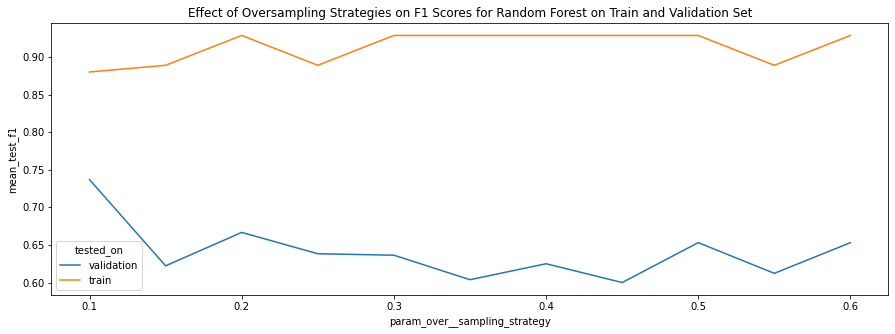

In [277]:
# Concatenating and saving

# Metrics of interest
metrics_of_interest = ['mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy', 'mean_fit_time']
oversamplings_metrics = ['param_over__sampling_strategy'] + metrics_of_interest

# # Extracting the data from grid searches
# gslos = pd.DataFrame(grid_search_log_oversampling.cv_results_)[oversamplings_metrics] # gridsearch log oversampling - gslos
# gsdos = pd.DataFrame(grid_search_dtree_oversampling.cv_results_)[oversamplings_metrics] # gridsearch dtree oversampling - gsdos
# gsros = pd.DataFrame(grid_search_rfc_oversampling.cv_results_)[oversamplings_metrics] # gridsearch rfc oversampling - gsros

# # Creating extra columns with model name
# gslos['model'] = 'log'
# gsdos['model'] = 'dtree'
# gsros['model'] = 'rfc'

# # concatenate
# grid_oversampling_results = pd.concat([gslos, gsdos, gsros])

# plt.figure(figsize=(15,5))
# sns.lineplot(data=grid_oversampling_results, x='param_over__sampling_strategy', y='mean_test_f1', hue='model')
# plt.title('Effect of Overampling Strategies on F1 Scores for Different Models')
# plt.show()

gsros_v = pd.DataFrame(grid_search_rfc_v_oversampling.cv_results_)[oversamplings_metrics] # gridsearch rfc undersampling - gsrus_v
gsros_t = pd.DataFrame(grid_search_rfc_t_oversampling.cv_results_)[oversamplings_metrics] # gridsearch rfc undersampling - gsrus_t

# concatenate
grid_oversampling_results = pd.concat([gsros_v, gsros_t])
grid_oversampling_results['tested_on'] = ['validation']*len(gsros_v) + ['train']*len(gsros_t)

plt.figure(figsize=(15,5))
sns.lineplot(data=grid_oversampling_results, x='param_over__sampling_strategy', y='mean_test_f1', hue='tested_on')
plt.title('Effect of Oversampling Strategies on F1 Scores for Random Forest on Train and Validation Set')
plt.show()

**Comment:** SMOTE causes our model to overfit drastically, as seen in the improvement on just the train, but the decrease in performance in the validation set. The highest as at 0.1, which is almost similar to no oversampling applied. We won't be exploring any model from here. We see no converge, and no parameter is attractive. We will now look to the paper by Chawla et al. (2002) to take on their advice of combining undersampling with oversampling.  

### Combination

In [289]:
rfc_v = Pipeline(steps=[
    ('under', RandomUnderSampler(random_state=101)), 
    ('over', SMOTE(random_state=101)),
    ('rfc', RandomForestClassifier(criterion='gini', 
                                   min_samples_leaf=3,
                                   min_samples_split=3, max_depth =50, n_estimators=70, 
                                   random_state=101, n_jobs=-1))])

rfc_t = Pipeline(steps=[
    ('under', RandomUnderSampler(random_state=101)), 
    ('over', SMOTE(random_state=101)),
    ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                   min_samples_split=3, max_depth =50, n_estimators=70, 
                                   random_state=101, n_jobs=-1))])


In [290]:
# Params to explore

param_sampling = {
    'under__sampling_strategy': [0.15, 0.175, 0.2], 
    'over__sampling_strategy': [0.225, 0.25, 0.275] 
} # 

In [291]:
# Redefining Scoring

scoring = ['recall', 'precision', 'f1', 'accuracy']

In [292]:
# Sampling grid search

# grid_search_log_sampling = GridSearchCV(log, param_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
# grid_search_dtree_sampling = GridSearchCV(dtree, param_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_v_sampling = GridSearchCV(rfc_v, param_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_t_sampling = GridSearchCV(rfc_t, param_sampling, cv=pds2, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)

In [293]:
# Fitting 

# grid_search_log_sampling.fit(X_train_val_comb, y_train_val_comb)
# grid_search_dtree_sampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_v_sampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_t_sampling.fit(X_train_train_comb, y_train_train_comb)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise',
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=101)),
                                       ('over', SMOTE(random_state=101)),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=50,
                                                               min_samples_leaf=3,
                                                               min_samples_split=3,
                                                               n_estimators=70,
                                                               n_jobs=-1,
                                                               random_state=101))]),
             n_jobs=-1,
             param_grid={'over__sampling_strategy': [0.225, 0.25, 0.275],
                         'under__sampling_strategy': [0.15, 0.1

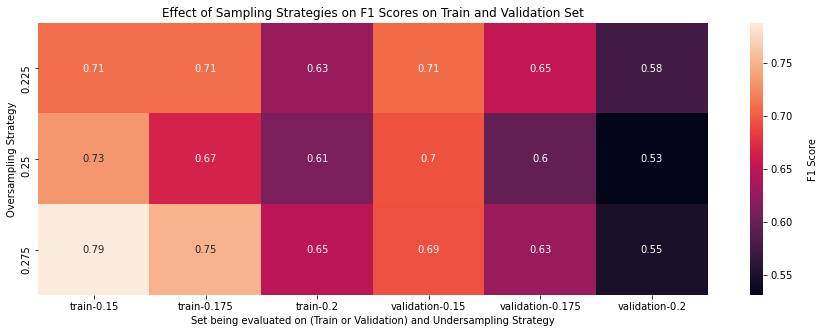

In [381]:
# Concatenating and saving

# Metrics of interest
metrics_of_interest = ['mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy', 'mean_fit_time']
samplings_metrics = ['param_over__sampling_strategy', 'param_under__sampling_strategy'] + metrics_of_interest

# Extracting the data from grid searches
# gsls = pd.DataFrame(grid_search_log_sampling.cv_results_)[samplings_metrics] # gridsearch log sampling - gsls
# gsds = pd.DataFrame(grid_search_dtree_sampling.cv_results_)[samplings_metrics] # gridsearch dtree sampling - gsds
gsrs_v = pd.DataFrame(grid_search_rfc_v_sampling.cv_results_)[samplings_metrics] # gridsearch rfc sampling - gsrs
gsrs_t = pd.DataFrame(grid_search_rfc_t_sampling.cv_results_)[samplings_metrics]

# Creating extra columns with model name
# gsls['model'] = 'log'
# gsds['model'] = 'dtree'
# gsrs['model'] = 'rfc'
gsrs_v['trained_on'] = 'validation'
gsrs_t['trained_on'] = 'train'

# concatenate
# grid_sampling_results = pd.concat([gsls, gsds, gsrs])
grid_sampling_results = pd.concat([gsrs_v, gsrs_t])

# reorganise
sampling_f1 = pd.pivot_table(grid_sampling_results, values='mean_test_f1',
                             index='param_over__sampling_strategy', 
                             columns = ['trained_on', 'param_under__sampling_strategy'],
                             aggfunc=np.mean)

plt.figure(figsize=(15,5))
sns.heatmap(sampling_f1, annot=True, cbar_kws={'label': '\nF1 Score'})
plt.xlabel('Set being evaluated on (Train or Validation) and Undersampling Strategy')
plt.ylabel('Oversampling Strategy')
plt.title('Effect of Sampling Strategies on F1 Scores on Train and Validation Set')
plt.savefig('./Model_Evaluation_Images/over_and_undersampling.png',  bbox_inches='tight')

**Comment:** None of the combinations have surpassed F1 score on the validation set from the hyperparameter tuning stage. However, one combination of parameters from under and oversampling have produced results very close to one another between train and validation sets. They are the upper left blocks of both the train and validation sets - 71% validation score. This can be determined from the blocks with closely similar colors in the left and right side of the heatmap.

# Full Train and Test

We are interested in 4 Random Forest Classifier Models to test on the test set:
1. Default parameters
2. Hyperparameter tuned
3. Undersampling
4. Combination of undersampling and oversampling

In [388]:
# Defining models

# d --> default
rfc_d = RandomForestClassifier(random_state=101) 

# ht --> hyperparameter tuned
rfc_ht = RandomForestClassifier(criterion='gini', 
                                min_samples_leaf=3,
                                min_samples_split=3, 
                                max_depth = 50, 
                                n_estimators=70, 
                                random_state=101, 
                                n_jobs=-1)


# c --> combination of sampling strategies
rfc_c = Pipeline(steps=[('under', RandomUnderSampler(random_state=101, sampling_strategy=0.15)), 
                        ('over', SMOTE(random_state=101, sampling_strategy=0.225)),
                        ('rfc', RandomForestClassifier(criterion='gini', 
                                                       min_samples_leaf=3,
                                                       min_samples_split=3, 
                                                       max_depth =50, 
                                                       n_estimators=70, 
                                                       random_state=101, 
                                                       n_jobs=-1))])

models = [rfc_d, rfc_ht, rfc_c]
labels = ['default', 'hyperparameter_tuned', 'sampling_combination']

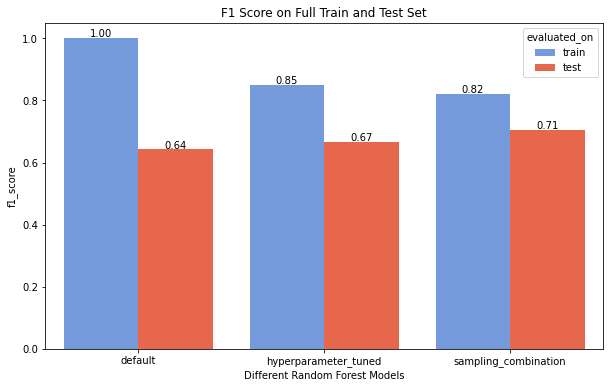

In [389]:
see_results_train_test = shortlist_models(models, labels, X_fulltrain, y_fulltrain, X_test, y_test, 2)

# Visualising results

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='f1_score', hue='evaluated_on', data=see_results_train_test, palette=['#6495ED', '#FF5733'])
plt.title('F1 Score on Full Train and Test Set')
show_values(g)
plt.xlabel('Different Random Forest Models')
plt.savefig('./Model_Evaluation_Images/f1_scores_testing_stage.png',  bbox_inches='tight')

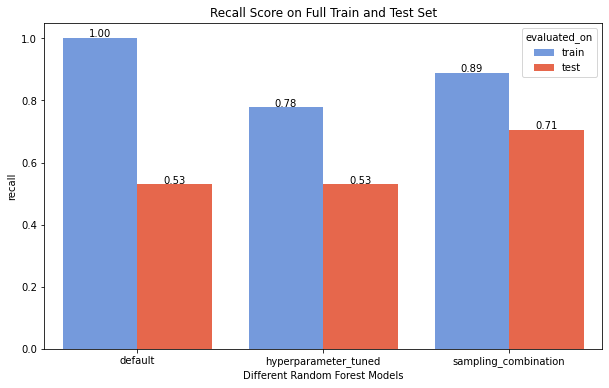

In [390]:
# Recall

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='recall', hue='evaluated_on', data=see_results_train_test, palette=['#6495ED', '#FF5733'])
plt.title('Recall Score on Full Train and Test Set')
show_values(g)
plt.xlabel('Different Random Forest Models')
plt.show();

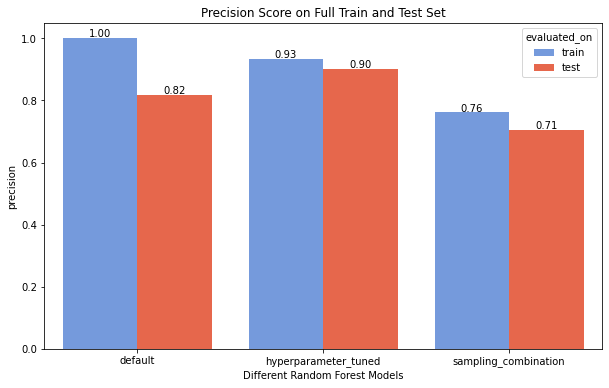

In [391]:
# Precision

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='precision', hue='evaluated_on', data=see_results_train_test, palette=['#6495ED', '#FF5733'])
plt.title('Precision Score on Full Train and Test Set')
show_values(g)
plt.xlabel('Different Random Forest Models')
plt.show();

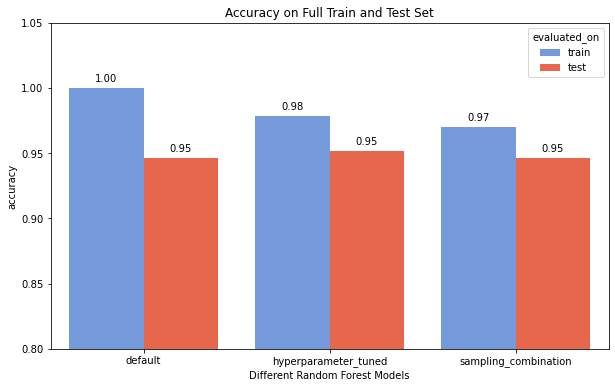

In [392]:
# Accuracy

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='accuracy', hue='evaluated_on', data=see_results_train_test, palette=['#6495ED', '#FF5733'])
plt.title('Accuracy on Full Train and Test Set')
show_values(g)
plt.ylim(0.8, 1.05)
plt.xlabel('Different Random Forest Models')
plt.savefig('./Model_Evaluation_Images/accuracy_scores_testing_stage.png',  bbox_inches='tight')

**Comment:** The Random Forest Classifier with sampling combination has a higher F1_score, which has the same value for both precision and recall. It is able to detect successes with a higher recall and precision, which is what we are looking for. Additionally, this is the model we will use to discern what contributes to the success. 

In [321]:
rfc_c[2].feature_importances_

array([0.08745537, 0.10166704, 0.09054666, 0.03564184, 0.02091054,
       0.04829378, 0.01538233, 0.08144666, 0.06490114, 0.01152989,
       0.02278417, 0.11646994, 0.00561346, 0.04127779, 0.07404179,
       0.05876358, 0.03169208, 0.01686734, 0.02524431, 0.04947029])

In [325]:
# pk.dump(rfc_c, open('./Final_Model/Final_RandomForestClassifier.pkl', 'wb'))

In [334]:
see_results_train_test

,model,evaluated_on,accuracy,f1_score,recall,precision
0,default,train,1.000000,1.000000,1.000000,1.000000
1,hyperparameter_tuned,train,0.978587,0.848485,0.777778,0.933333
2,undersampled,train,0.957173,0.756098,0.861111,0.673913
3,sampling_combination,train,0.970021,0.820513,0.888889,0.761905
4,default,test,0.946237,0.642857,0.529412,0.818182
5,hyperparameter_tuned,test,0.951613,0.666667,0.529412,0.900000
6,undersampled,test,0.930108,0.648649,0.705882,0.600000
7,sampling_combination,test,0.946237,0.705882,0.705882,0.705882


In [343]:
temp = see_results_train_test.iloc[7, 2:].to_frame().reset_index()
temp.columns = ['Metric', 'Value']
temp.style.hide_index()

Metric,Value
accuracy,0.946237
f1_score,0.705882
recall,0.705882
precision,0.705882
